In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
DATA_PATH = "bank.csv"   # <-- replace with your actual file name!!! (e.g., bank.csv, dataset.csv)
OUTCOME_COL = "deposit"  # Actual outcome column
TREAT_COL = "campaign"   # Will convert to binary treatment later


Dataset Columns: Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')
X Shape: (11162, 41)
Cross-fitting completed!

===== ATE RESULTS =====
ATE: -0.03194085000056886
Standard Error: 0.0077337772775557
95% CI: (np.float64(-0.04709905346457803), np.float64(-0.016782646536559684))
p-value: 3.6269186302728684e-05

CATE saved to dml_results.csv


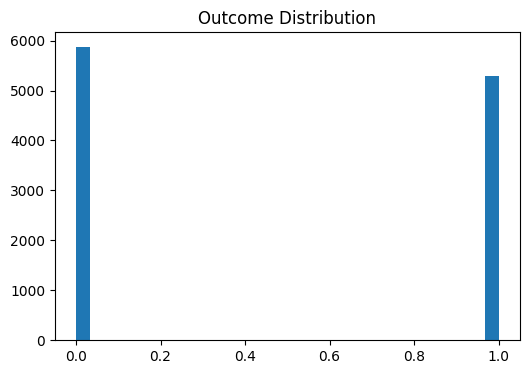

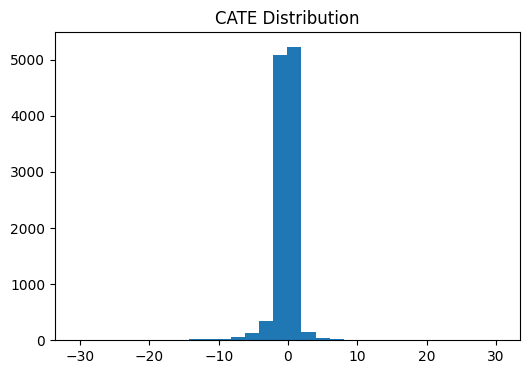

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import norm

# --------------------
# LOAD DATA
# --------------------
# LOAD DATA
df = pd.read_csv("/content/drive/MyDrive/datasets/bank.csv")
print("Dataset Columns:", df.columns)


# Convert outcome (yes/no) → 1/0
df[OUTCOME_COL] = df[OUTCOME_COL].map({"yes": 1, "no": 0})

# Convert treatment (campaign count) → binary 1/0
df[TREAT_COL] = (df[TREAT_COL] > 1).astype(int)

# Prepare X, Y, T
Y = df[OUTCOME_COL].astype(float)
T = df[TREAT_COL].astype(int)
X = df.drop(columns=[OUTCOME_COL, TREAT_COL], errors='ignore')

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

print("X Shape:", X.shape)

# --------------------
# CROSS-FIT M(x) and G(x)
# --------------------
def crossfit(X, Y, T, K=5):
    n = X.shape[0]
    m_hat = np.zeros(n)
    g_hat = np.zeros(n)

    kf = KFold(n_splits=K, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr = Y.iloc[train_idx]
        t_tr = T.iloc[train_idx]

        # Outcome model m(x)
        m_model = make_pipeline(SimpleImputer(), StandardScaler(), LassoCV(cv=3))
        m_model.fit(X_tr, y_tr)
        m_hat[test_idx] = m_model.predict(X_te)

        # Propensity score model g(x)
        g_model = make_pipeline(SimpleImputer(), RandomForestClassifier(n_estimators=200))
        g_model.fit(X_tr, t_tr)
        g_hat[test_idx] = g_model.predict_proba(X_te)[:, 1]

    # clamp g(x)
    g_hat = np.clip(g_hat, 0.01, 0.99)

    return m_hat, g_hat

m_hat, g_hat = crossfit(X, Y, T)
print("Cross-fitting completed!")

# --------------------
# ATE ESTIMATION
# --------------------
resid_y = Y - m_hat
resid_t = T - g_hat

theta = np.sum(resid_t * resid_y) / np.sum(resid_t ** 2)

psi = (resid_t * resid_y) - theta * (resid_t ** 2)
se = np.sqrt(np.var(psi) / (len(Y) * (np.mean(resid_t ** 2))**2))

z = 1.96
ci_low = theta - z * se
ci_high = theta + z * se
t_stat = theta / se
p_value = 2 * (1 - norm.cdf(abs(t_stat)))

print("\n===== ATE RESULTS =====")
print("ATE:", theta)
print("Standard Error:", se)
print("95% CI:", (ci_low, ci_high))
print("p-value:", p_value)

# --------------------
# CATE ESTIMATION
# --------------------
pseudo = (Y - m_hat) / (T - g_hat)

# clamp denominator
pseudo = np.where(np.isfinite(pseudo), pseudo, 0)

cate_model = RandomForestRegressor(n_estimators=300)
cate_model.fit(X, pseudo)
cate = cate_model.predict(X)

df["CATE"] = cate
df.to_csv("dml_results.csv", index=False)
print("\nCATE saved to dml_results.csv")

# --------------------
# PLOTS
# --------------------
plt.figure(figsize=(6,4))
plt.hist(Y, bins=30)
plt.title("Outcome Distribution")
plt.savefig("outcome_dist.png")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(cate, bins=30)
plt.title("CATE Distribution")
plt.savefig("cate_dist.png")
plt.show()


In [17]:
import os

OUTPUT_DIR = "dml_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Output folder created:", OUTPUT_DIR)


Output folder created: dml_output


In [18]:
# Save results CSV
df.to_csv(f"{OUTPUT_DIR}/dml_results.csv", index=False)

# Save plots
plt.figure(figsize=(6,4))
plt.hist(Y, bins=30)
plt.title("Outcome Distribution")
plt.savefig(f"{OUTPUT_DIR}/outcome_distribution.png")
plt.close()

plt.figure(figsize=(6,4))
plt.hist(cate, bins=30)
plt.title("CATE Distribution")
plt.savefig(f"{OUTPUT_DIR}/cate_distribution.png")
plt.close()

print("All files saved into:", OUTPUT_DIR)


All files saved into: dml_output


In [19]:
import shutil

shutil.make_archive("dml_output", "zip", OUTPUT_DIR)

print("Download your zip file:")


Download your zip file:


In [20]:
from google.colab import files
files.download("dml_output.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>